# Notes

Used simplified version of the data used in the paper "Embeddings from protein language models predict conservation and variant effects" by Marquet et al.

**Data explanation**:
- `sequence.fasta`: FASTA file with the sequences of the proteines in the dataset
- `/labels/effect/*.effect`: Files with the SAVs of each protein. Encoded as, e.g., "X11Y 1" where X is the original AA, Y is the mutated AA, 11 is the position (1-indexed) and the last 1 means effect SAV and 0 means neutral SAV.
- `/labels/neutral/*.effect`: Same as `/labels/effect/*.effect`.

**Proposed splits**:
- `mixed`: cluster components (20% PIDE) and wild types for training and cluster representatives for testing
- `human`: same as mixed, but using only human sequences

# Configs & Imports

In [1]:
from os import path
from pathlib import Path

from pandas import DataFrame, read_csv
from numpy import NaN, isnan
import itertools

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import textdistance

import matplotlib.pyplot as plt
from IPython.display import display

from tqdm import tqdm

%load_ext autoreload
%autoreload 2

In [3]:
# Where the raw data is stored and where processed data will be deposited
data_path = Path('') / '..' / 'data' / 'sav'

neutral_path = data_path / 'labels' / 'neutral'
neutral_files = neutral_path.rglob('*.effect')

effect_path = data_path / 'labels' / 'effect'
effect_files = effect_path.rglob('*.effect')

split_path = Path('') / '..' / 'splits' / 'sav'

all_clustering_path = split_path / 'all_sav_DB_clu.tsv'
human_clustering_path = split_path / 'only_sav_human_DB_clu.tsv'

# Obtain original dataset

In [35]:
# Function to encapsulate the fasta data files
def getProteinsFromFASTAFile(filePath):
    columns = ["id", "sequence", "neutral", "effect"]
    dataset = DataFrame(columns = columns)
    
    for protein in tqdm(SeqIO.parse(filePath, "fasta")):
        dataset = dataset.append({"id": protein.id,
                                  "sequence": str(protein.seq)}, ignore_index=True)
    
    return dataset

In [36]:
# If available we use the FASTA file converted to CSV because
# processing this FASTA file takes too long.
if path.exists(split_path / 'sequences_dataframe.csv'):
    data = read_csv(split_path / 'sequences_dataframe.csv')
else:
    data = getProteinsFromFASTAFile(data_path / "sequences.fasta")
    data.to_csv(split_path / 'sequences_dataframe.csv', index=False)

In [37]:
# Get the neutral SAVs
neutral_sav = dict()
for path in tqdm(neutral_files):
    name = str(path).split('/')[5]
    protein_name = name.split('.')[0]
    
    with open(path, 'r') as f:
        variations = f.read().splitlines()
        neutral_sav[protein_name] = list(map(lambda x: x.split(' ')[0], variations))

4233it [01:11, 59.03it/s] 


In [38]:
# Get the effect SAVs
effect_sav = dict()
for path in tqdm(effect_files):
    name = str(path).split('/')[5]
    protein_name = name.split('.')[0]
    
    with open(path, 'r') as f:
        variations = f.read().splitlines()
        effect_sav[protein_name] = list(map(lambda x: x.split(' ')[0], variations))

7387it [01:40, 73.43it/s] 


In [39]:
# Add effect and neutral SAV to the dataframe
for i in tqdm(range(len(data))):
    id = data.iloc[i]["id"]
    
    if id in set(neutral_sav.keys()):
        data["neutral"].iloc[i] = neutral_sav[id]
    
    if id in set(effect_sav.keys()):
        data["effect"].iloc[i] = effect_sav[id]

  0%|                                                  | 0/9660 [00:00<?, ?it/s]/Users/joaquimgomez/opt/anaconda3/envs/rostlab/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
100%|██████████████████████████████████████| 9660/9660 [01:20<00:00, 119.40it/s]


In [40]:
# Let's delete the proteins with < 40 residues
count_aa = [len(data.iloc[i].sequence) for i in range(len(data))]
indexes_less_40 = [i for i in range(len(count_aa)) if count_aa[i] < 40]
data = data.drop(index=indexes_less_40)
data = data.reset_index(drop=True)

In [41]:
# Check the dataset
data

,id,sequence,neutral,effect
0,A40493@yana,MEVSPLQPVNENMQVNKIKKNEDAKKRLSVERIYQKKTQLEHILLR...,NaN,"[R449Q, R486K]"
1,S17875@yana,MPFPVTTQGSQQTQPPQKHYGITSPISLAAPKETDCLLTQKLVETL...,[K96H],"[D125A, D125S, D128A, F100A, F100I, F98N, F98S..."
2,S37460@yana,MRRNSRARLGVSLLLVAGALGLGAAPSTAADTPPAAPSAIPAPSAY...,NaN,"[H315V, H340A, S328A, S328G]"
3,DCLBHP@yana,MSELDAKLNKLGVDRIAISPYKQWTRGYMEPGNIGNGYVTGLKVDA...,NaN,"[D199N, D54N, D64N, G59D, I60A, I60V, Y63F]"
4,AJECDS@yana,MGNNVVVLGTQWGDEGKGKIVDLLTERAKYVVRYQGGHNAGHTLVI...,NaN,"[D334E, D334N, D334Q, G13V, G16V, G18V, I20T, ..."
...,...,...,...,...
9641,A940612@direct1,RVTLSSKPQALATPNKEEHGKRKKKGKGLGKKRDPCLRKYKDFCIH...,"[K16A, K21A, K23A, K24A, K25A, K27A, K53A, R22...",NaN
9642,A984244@direct1,NTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAG...,"[A37E, D42A, E16A, E26A, E29A, E33A, E36A, E39...",NaN
9643,A000292@direct1,MAQTPAFDKPKVELHVHLDGSIKPETILYYGRRRGIALPANTAEGL...,"[A131D, D143A, E128D, G134N]",NaN
9644,A983849@direct1,MPEISLRHVVSGSSQDSTHCAENLLKADTYRKWRAATAGEKTISVV...,[Q221L],NaN


# Statistics

In [42]:
# Number of proteins with neutral and/or effect SAVs
count_neutral_proteins = len(data.loc[data["neutral"].notnull()])
count_effect_proteins = len(data.loc[data["effect"].notnull()])
count_only_neutral_proteins = len(data.loc[data["neutral"].notnull() & data["effect"].isnull()])
count_only_effect_proteins = len(data.loc[data["neutral"].isnull() & data["effect"].notnull()])
count_neutral_and_effect_proteins = len(data.loc[data["neutral"].notnull() & data["effect"].notnull()])


display("Number of proteins with neutral SAVs: " + str(count_neutral_proteins))
display("Number of proteins with effect SAVs: " + str(count_effect_proteins))
display("Number of proteins with only neutral SAVs: " + str(count_only_neutral_proteins))
display("Number of proteins with only effect SAVs: " + str(count_only_effect_proteins))
display("Number of proteins with neutral and effect SAVs: " + str(count_neutral_and_effect_proteins))

'Number of proteins with neutral SAVs: 4229'

'Number of proteins with effect SAVs: 7374'

'Number of proteins with only neutral SAVs: 2272'

'Number of proteins with only effect SAVs: 5417'

'Number of proteins with neutral and effect SAVs: 1957'

In [43]:
# Number of residues and number of residues with neutral or effect SAV
count_aa = [len(data.iloc[i].sequence) for i in range(len(data))]
neutral_savs = [data["neutral"].iloc[i] for i in range(len(data)) if i in data.loc[data["neutral"].notnull()].index]
effect_savs = [data["effect"].iloc[i] for i in range(len(data)) if i in data.loc[data["effect"].notnull()].index]

display("Total number of AAs: " + str(sum(count_aa)))
display("Size of the smallest protein: " + str(min(count_aa)))
display("Size of the largest protein: " + str(max(count_aa)))
display("Number of neutral SAVs: " + str(sum([len(protein_neutral_savs) for protein_neutral_savs in neutral_savs])))
display("Number of effect SAVs: " + str(sum([len(protein_effect_savs) for protein_effect_savs in effect_savs])))

'Total number of AAs: 4983475'

'Size of the smallest protein: 40'

'Size of the largest protein: 4967'

'Number of neutral SAVs: 39689'

'Number of effect SAVs: 60988'

In [44]:
# Let's count the different possible mutations
alphabet = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N',
           'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
possible_mutations = list(itertools.permutations(alphabet, 2))

count_all_mutations = {possible_mutations[i] : 0 for i in range(len(possible_mutations))}
count_neutral_mutations = {possible_mutations[i] : 0 for i in range(len(possible_mutations))}
count_effect_mutations = {possible_mutations[i] : 0 for i in range(len(possible_mutations))}
for i in range(len(data)):
    if i in data.loc[data["neutral"].notnull()].index:
        for j in range(len(data.iloc[i]["neutral"])):
            from_res = data.iloc[i]["neutral"][j][0]
            to_res = data.iloc[i]["neutral"][j][-1]
            count_all_mutations[(from_res, to_res)] += 1
            count_neutral_mutations[(from_res, to_res)] += 1
        
    if i in data.loc[data["effect"].notnull()].index:
        for j in range(len(data.iloc[i]["effect"])):
            from_res = data.iloc[i]["effect"][j][0]
            to_res = data.iloc[i]["effect"][j][-1]
            count_all_mutations[(from_res, to_res)] += 1
            count_effect_mutations[(from_res, to_res)] += 1

In [45]:
count_all_mutations

{('A', 'C'): 152,
 ('A', 'D'): 340,
 ('A', 'E'): 376,
 ('A', 'F'): 77,
 ('A', 'G'): 544,
 ('A', 'H'): 59,
 ('A', 'I'): 78,
 ('A', 'K'): 121,
 ('A', 'L'): 146,
 ('A', 'M'): 45,
 ('A', 'N'): 86,
 ('A', 'P'): 493,
 ('A', 'Q'): 90,
 ('A', 'R'): 129,
 ('A', 'S'): 878,
 ('A', 'T'): 1084,
 ('A', 'V'): 1059,
 ('A', 'W'): 36,
 ('A', 'Y'): 50,
 ('C', 'A'): 785,
 ('C', 'D'): 49,
 ('C', 'E'): 15,
 ('C', 'F'): 206,
 ('C', 'G'): 294,
 ('C', 'H'): 46,
 ('C', 'I'): 23,
 ('C', 'K'): 13,
 ('C', 'L'): 54,
 ('C', 'M'): 21,
 ('C', 'N'): 15,
 ('C', 'P'): 18,
 ('C', 'Q'): 17,
 ('C', 'R'): 446,
 ('C', 'S'): 1323,
 ('C', 'T'): 47,
 ('C', 'V'): 61,
 ('C', 'W'): 135,
 ('C', 'Y'): 502,
 ('D', 'A'): 1393,
 ('D', 'C'): 80,
 ('D', 'E'): 1178,
 ('D', 'F'): 41,
 ('D', 'G'): 517,
 ('D', 'H'): 265,
 ('D', 'I'): 23,
 ('D', 'K'): 211,
 ('D', 'L'): 71,
 ('D', 'M'): 10,
 ('D', 'N'): 1760,
 ('D', 'P'): 57,
 ('D', 'Q'): 97,
 ('D', 'R'): 115,
 ('D', 'S'): 232,
 ('D', 'T'): 86,
 ('D', 'V'): 258,
 ('D', 'W'): 10,
 ('D', 'Y'): 26

In [46]:
count_neutral_mutations

{('A', 'C'): 104,
 ('A', 'D'): 112,
 ('A', 'E'): 208,
 ('A', 'F'): 24,
 ('A', 'G'): 374,
 ('A', 'H'): 29,
 ('A', 'I'): 50,
 ('A', 'K'): 77,
 ('A', 'L'): 76,
 ('A', 'M'): 25,
 ('A', 'N'): 60,
 ('A', 'P'): 165,
 ('A', 'Q'): 69,
 ('A', 'R'): 82,
 ('A', 'S'): 706,
 ('A', 'T'): 479,
 ('A', 'V'): 422,
 ('A', 'W'): 9,
 ('A', 'Y'): 24,
 ('C', 'A'): 304,
 ('C', 'D'): 11,
 ('C', 'E'): 2,
 ('C', 'F'): 25,
 ('C', 'G'): 56,
 ('C', 'H'): 12,
 ('C', 'I'): 10,
 ('C', 'K'): 3,
 ('C', 'L'): 22,
 ('C', 'M'): 7,
 ('C', 'N'): 3,
 ('C', 'P'): 4,
 ('C', 'Q'): 7,
 ('C', 'R'): 39,
 ('C', 'S'): 389,
 ('C', 'T'): 17,
 ('C', 'V'): 22,
 ('C', 'W'): 6,
 ('C', 'Y'): 30,
 ('D', 'A'): 439,
 ('D', 'C'): 24,
 ('D', 'E'): 670,
 ('D', 'F'): 6,
 ('D', 'G'): 126,
 ('D', 'H'): 55,
 ('D', 'I'): 7,
 ('D', 'K'): 78,
 ('D', 'L'): 12,
 ('D', 'M'): 4,
 ('D', 'N'): 513,
 ('D', 'P'): 27,
 ('D', 'Q'): 43,
 ('D', 'R'): 36,
 ('D', 'S'): 98,
 ('D', 'T'): 54,
 ('D', 'V'): 29,
 ('D', 'W'): 0,
 ('D', 'Y'): 24,
 ('E', 'A'): 633,
 ('E', 'C')

In [47]:
count_effect_mutations

{('A', 'C'): 48,
 ('A', 'D'): 228,
 ('A', 'E'): 168,
 ('A', 'F'): 53,
 ('A', 'G'): 170,
 ('A', 'H'): 30,
 ('A', 'I'): 28,
 ('A', 'K'): 44,
 ('A', 'L'): 70,
 ('A', 'M'): 20,
 ('A', 'N'): 26,
 ('A', 'P'): 328,
 ('A', 'Q'): 21,
 ('A', 'R'): 47,
 ('A', 'S'): 172,
 ('A', 'T'): 605,
 ('A', 'V'): 637,
 ('A', 'W'): 27,
 ('A', 'Y'): 26,
 ('C', 'A'): 481,
 ('C', 'D'): 38,
 ('C', 'E'): 13,
 ('C', 'F'): 181,
 ('C', 'G'): 238,
 ('C', 'H'): 34,
 ('C', 'I'): 13,
 ('C', 'K'): 10,
 ('C', 'L'): 32,
 ('C', 'M'): 14,
 ('C', 'N'): 12,
 ('C', 'P'): 14,
 ('C', 'Q'): 10,
 ('C', 'R'): 407,
 ('C', 'S'): 934,
 ('C', 'T'): 30,
 ('C', 'V'): 39,
 ('C', 'W'): 129,
 ('C', 'Y'): 472,
 ('D', 'A'): 954,
 ('D', 'C'): 56,
 ('D', 'E'): 508,
 ('D', 'F'): 35,
 ('D', 'G'): 391,
 ('D', 'H'): 210,
 ('D', 'I'): 16,
 ('D', 'K'): 133,
 ('D', 'L'): 59,
 ('D', 'M'): 6,
 ('D', 'N'): 1247,
 ('D', 'P'): 30,
 ('D', 'Q'): 54,
 ('D', 'R'): 79,
 ('D', 'S'): 134,
 ('D', 'T'): 32,
 ('D', 'V'): 229,
 ('D', 'W'): 10,
 ('D', 'Y'): 238,
 ('E', '

In [48]:
# Let's count the number of proteins with 1, 2, 3, ... mutations
counts_of_protein_mutations = dict()
indexes_for_number_mutations = dict()

for i in range(len(data)):
    current_count = 0
    
    if i in data.loc[data["neutral"].notnull()].index:
        current_count += len(data.iloc[i]["neutral"])
        
    if i in data.loc[data["effect"].notnull()].index:
        current_count += len(data.iloc[i]["effect"])
    
    if current_count in counts_of_protein_mutations.keys():
        counts_of_protein_mutations[current_count] += 1
        indexes_for_number_mutations[current_count].append(i)
    else:
        counts_of_protein_mutations[current_count] = 1
        indexes_for_number_mutations[current_count] = [i]

In [49]:
for count in sorted(counts_of_protein_mutations):
    print("%s: %s" % (count, counts_of_protein_mutations[count]))

1: 1827
2: 1245
3: 953
4: 724
5: 506
6: 448
7: 371
8: 363
9: 294
10: 262
11: 225
12: 186
13: 182
14: 170
15: 133
16: 137
17: 107
18: 112
19: 102
20: 95
21: 80
22: 70
23: 60
24: 74
25: 66
26: 60
27: 44
28: 49
29: 42
30: 41
31: 49
32: 45
33: 28
34: 30
35: 26
36: 23
37: 35
38: 22
39: 16
40: 17
41: 25
42: 12
43: 7
44: 8
45: 6
46: 8
47: 12
48: 7
49: 9
50: 8
51: 6
52: 7
53: 5
54: 8
55: 4
56: 2
57: 2
58: 5
59: 3
60: 5
61: 6
62: 4
63: 5
64: 4
65: 1
66: 6
67: 7
68: 5
69: 5
70: 3
71: 3
72: 3
73: 2
74: 2
75: 4
76: 3
77: 2
78: 1
79: 1
80: 2
81: 5
82: 1
83: 3
84: 2
85: 4
86: 2
87: 1
88: 4
89: 2
91: 1
93: 4
94: 1
96: 1
97: 2
98: 3
99: 3
101: 2
102: 2
103: 2
104: 1
105: 1
107: 2
108: 1
110: 1
111: 1
112: 3
113: 1
114: 1
115: 1
116: 2
120: 3
121: 1
122: 2
124: 1
129: 1
131: 2
132: 2
133: 2
142: 1
143: 2
144: 1
145: 1
146: 2
149: 1
152: 1
153: 1
154: 1
156: 1
167: 1
169: 1
172: 1
173: 2
174: 1
184: 2
186: 1
196: 1
201: 1
235: 1
242: 1
254: 1
294: 1
336: 1
355: 1
364: 2
397: 1
444: 1
576: 1
1636: 1


<BarContainer object of 50 artists>

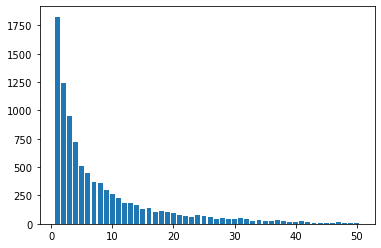

In [50]:
# We have insignificant number of proteins with > 45 mutations. We delete them to visualize the histogram
for i in [k for k in counts_of_protein_mutations.keys() if k > 50]:
    del counts_of_protein_mutations[i]

# Plot histogram
plt.bar(counts_of_protein_mutations.keys(), counts_of_protein_mutations.values())

In [51]:
# Let's count the number of residues with more than one variation
residues_with_more_than_one_variation = {}

for i in range(len(data)):
    if i in data.loc[data["neutral"].notnull()].index:
        for j in range(len(data.iloc[i]["neutral"])):
            position = int(data.iloc[i]["neutral"][j][1:-1])
            if (i, position) in residues_with_more_than_one_variation:
                residues_with_more_than_one_variation[(i, position)] += 1
            else:
                residues_with_more_than_one_variation[(i, position)] = 1
    
    if i in data.loc[data["effect"].notnull()].index:
        for j in range(len(data.iloc[i]["effect"])):
            position = int(data.iloc[i]["effect"][j][1:-1])
            if (i, position) in residues_with_more_than_one_variation:
                residues_with_more_than_one_variation[(i, position)] += 1
            else:
                residues_with_more_than_one_variation[(i, position)] = 1

In [52]:
residues_with_more_than_one_variation

{(0, 449): 1,
 (0, 486): 1,
 (1, 96): 2,
 (1, 125): 2,
 (1, 128): 1,
 (1, 100): 2,
 (1, 98): 2,
 (2, 315): 1,
 (2, 340): 1,
 (2, 328): 2,
 (3, 199): 1,
 (3, 54): 1,
 (3, 64): 1,
 (3, 59): 1,
 (3, 60): 2,
 (3, 63): 1,
 (4, 334): 3,
 (4, 13): 1,
 (4, 16): 1,
 (4, 18): 1,
 (4, 20): 1,
 (4, 19): 1,
 (4, 332): 2,
 (4, 148): 1,
 (4, 304): 1,
 (4, 305): 1,
 (4, 306): 1,
 (5, 127): 1,
 (5, 49): 1,
 (6, 97): 1,
 (7, 418): 1,
 (7, 417): 1,
 (7, 398): 1,
 (7, 419): 1,
 (8, 34): 1,
 (8, 11): 1,
 (8, 57): 1,
 (8, 59): 1,
 (8, 60): 1,
 (8, 61): 2,
 (9, 136): 1,
 (9, 46): 1,
 (9, 219): 1,
 (9, 39): 4,
 (9, 15): 2,
 (9, 184): 1,
 (9, 20): 1,
 (9, 157): 2,
 (9, 215): 1,
 (9, 153): 5,
 (10, 225): 1,
 (10, 232): 1,
 (10, 250): 1,
 (10, 312): 1,
 (10, 243): 1,
 (10, 258): 1,
 (10, 281): 1,
 (10, 288): 1,
 (10, 302): 1,
 (11, 65): 1,
 (11, 38): 1,
 (11, 20): 1,
 (12, 168): 1,
 (12, 165): 1,
 (12, 157): 2,
 (12, 38): 1,
 (12, 100): 1,
 (12, 166): 1,
 (13, 101): 1,
 (13, 102): 1,
 (13, 153): 1,
 (13, 136): 1

In [53]:
# Count human proteins
human_ids = []

for i in range(len(data)):
    if "HUMAN" in data.iloc[i]["id"]:
        human_ids.append(data.iloc[i]["id"])

print("Human proteins: " + str(len(human_ids)))

Human proteins: 959


# Expanded datasets

In [54]:
wildtypes = DataFrame(columns = ["id", "sequence", "mutation_mask"])
savs = DataFrame(columns = ["id", "sequence", "mutation_index", "mutation_mask"])

In [119]:
# Let's create the (expanded) dataframe of wild types
for i in tqdm(range(len(data))):
    wildtypes = wildtypes.append({
        "id": data.iloc[i]["id"],
        "sequence": data.iloc[i]["sequence"],
        "mutation_mask": "".join(['0']*len(data.iloc[i]["sequence"]))
    }, ignore_index = True)

100%|███████████████████████████████████████| 9646/9646 [04:22<00:00, 36.69it/s]


In [55]:
# Let's create the (expanded) dataframe of SAVS
# First save in dictionary because it is more efficient than DataFrame.append()
dict_index = 0
savs_dict = dict()
for i in tqdm(range(len(data))):
    if i in data.loc[data["neutral"].notnull()].index:
        for j in range(len(data.iloc[i]["neutral"])):
            mutant_seq = list(data.iloc[i]["sequence"])
            mutation_index = int(data.iloc[i]["neutral"][j][1:-1])
            mutation_mask = ['0']*len(data.iloc[i]["sequence"])

            mutant_seq[mutation_index - 1] = data.iloc[i]["neutral"][j][-1]
            mutation_mask[mutation_index - 1] = '1'

            savs_dict[dict_index] = {
                "id": data.iloc[i]["id"],
                "sequence": "".join(mutant_seq),
                "mutation_index": mutation_index,
                "mutation_mask": "".join(mutation_mask)
            }

            dict_index += 1

    if i in data.loc[data["effect"].notnull()].index:
        for j in range(len(data.iloc[i]["effect"])):
            mutant_seq = list(data.iloc[i]["sequence"])
            mutation_index = int(data.iloc[i]["effect"][j][1:-1])
            mutation_mask = ['0']*len(data.iloc[i]["sequence"])

            mutant_seq[mutation_index - 1] = data.iloc[i]["effect"][j][-1]
            mutation_mask[mutation_index - 1] = '2'

            savs_dict[dict_index] = {
                "id": data.iloc[i]["id"],
                "sequence": "".join(mutant_seq),
                "mutation_index": mutation_index,
                "mutation_mask": "".join(mutation_mask)
            }

            dict_index += 1

savs = DataFrame.from_dict(savs_dict, "index")
savs.to_csv(split_path / "savs.csv")

100%|███████████████████████████████████████| 9646/9646 [06:26<00:00, 24.98it/s]


In [56]:
# Let's look at the data
savs

,id,sequence,mutation_index,mutation_mask
0,A40493@yana,MEVSPLQPVNENMQVNKIKKNEDAKKRLSVERIYQKKTQLEHILLR...,449,0000000000000000000000000000000000000000000000...
1,A40493@yana,MEVSPLQPVNENMQVNKIKKNEDAKKRLSVERIYQKKTQLEHILLR...,486,0000000000000000000000000000000000000000000000...
2,S17875@yana,MPFPVTTQGSQQTQPPQKHYGITSPISLAAPKETDCLLTQKLVETL...,96,0000000000000000000000000000000000000000000000...
3,S17875@yana,MPFPVTTQGSQQTQPPQKHYGITSPISLAAPKETDCLLTQKLVETL...,125,0000000000000000000000000000000000000000000000...
4,S17875@yana,MPFPVTTQGSQQTQPPQKHYGITSPISLAAPKETDCLLTQKLVETL...,125,0000000000000000000000000000000000000000000000...
...,...,...,...,...
100672,A000292@direct1,MAQTPAFDKPKVELHVHLDGSIKPETILYYGRRRGIALPANTAEGL...,143,0000000000000000000000000000000000000000000000...
100673,A000292@direct1,MAQTPAFDKPKVELHVHLDGSIKPETILYYGRRRGIALPANTAEGL...,128,0000000000000000000000000000000000000000000000...
100674,A000292@direct1,MAQTPAFDKPKVELHVHLDGSIKPETILYYGRRRGIALPANTAEGL...,134,0000000000000000000000000000000000000000000000...
100675,A983849@direct1,MPEISLRHVVSGSSQDSTHCAENLLKADTYRKWRAATAGEKTISVV...,221,0000000000000000000000000000000000000000000000...


In [57]:
# Get human sequences from SAVs
human_savs_indexes = []
for i in range(len(savs)):
    if "HUMAN" in savs.iloc[i]["id"]:
        human_savs_indexes.append(i)

In [58]:
# Save SAV human sequences for clustering
sav_human_records = (SeqRecord(Seq(row.sequence),
                    id=str(index) + "-" + row.id,
                    name=row.id,
                    description="") for index, row in savs.loc[human_savs_indexes, ["id", "sequence"]].iterrows())

with open(split_path / "only_sav_human.fasta", "w") as f:
    SeqIO.write(sav_human_records, f, "fasta")

In [59]:
# Save all SAV sequences for clustering
all_sav_records = (SeqRecord(Seq(row.sequence),
                    id=str(index) + "-" + row.id,
                    name=row.id,
                    description="") for index, row in savs[["id", "sequence"]].iterrows())

with open(split_path / "all_sav.fasta", "w") as f:
    SeqIO.write(all_sav_records, f, "fasta")

# Splits

## mixed

In [60]:
# Let's load all clustered SAVS
all_clustering = read_csv(all_clustering_path, sep='	')

In [61]:
all_clustering

,cluster_representative,cluster_component
0,64-DEFFA@yana,64-DEFFA@yana
1,64-DEFFA@yana,65-DEFFA@yana
2,64-DEFFA@yana,66-DEFFA@yana
3,64-DEFFA@yana,67-DEFFA@yana
4,64-DEFFA@yana,68-DEFFA@yana
...,...,...
100672,86208-PCY2_HUMAN@ec,86212-PCY2_HUMAN@ec
100673,86208-PCY2_HUMAN@ec,86213-PCY2_HUMAN@ec
100674,86208-PCY2_HUMAN@ec,86214-PCY2_HUMAN@ec
100675,86208-PCY2_HUMAN@ec,86215-PCY2_HUMAN@ec


In [84]:
# Let's obtain the indexes in the SAVs dataframe for the representatives
all_representatives = all_clustering["cluster_representative"].unique()
all_representatives_indexes = set(map(lambda id: int(id.split('-')[0]), all_representatives))

In [102]:
# Let's obtain the indexes in the SAVs dataframe for the components
all_components = all_clustering["cluster_component"].unique()
all_components_indexes = set(map(lambda id: int(id.split('-')[0]), all_components))

# We consider only the indexes of components without representatives
all_components_indexes = all_components_indexes.difference(all_representatives_indexes)

In [127]:
# Let's create the split dataset
mixed = DataFrame(columns = ["sequence", "target", "set", "validation"])

# Add train samples (cluster components + wild types)
tmp = savs.iloc[list(all_components_indexes)][["sequence", "mutation_mask"]]
tmp.rename(columns = {"mutation_mask": "target"}, inplace = True)

wt_tmp = wildtypes[["sequence", "mutation_mask"]]
wt_tmp.rename(columns = {"mutation_mask": "target"}, inplace = True)

tmp = tmp.append(wt_tmp)
tmp.insert(2, "set", ["train"]*len(tmp))

mixed = mixed.append(tmp)

# Add validation samples
val_sample_indexes = list(mixed.sample(frac=0.1, random_state=1234).index)
validation = [True if i in val_sample_indexes else NaN for i in mixed.index]
mixed.validation = validation

# Add test samples (cluster representatives)
tmp = savs.iloc[list(all_representatives_indexes)][["sequence", "mutation_mask"]]
tmp.rename(columns = {"mutation_mask": "target"}, inplace = True)
tmp.insert(2, "set", ["test"]*len(tmp))
mixed = mixed.append(tmp)

mixed = mixed.reset_index(drop = True)

/Users/joaquimgomez/opt/anaconda3/envs/rostlab/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [131]:
mixed.to_csv(split_path / 'splits' / 'mixed.csv', index = False)

## human

In [16]:
# Let's load human clustered SAVS
human_clustering = read_csv(human_clustering_path, sep='	')

In [17]:
human_clustering

,cluster_representative,cluster_component
0,31475-GHR_HUMAN@pmd,31475-GHR_HUMAN@pmd
1,31475-GHR_HUMAN@pmd,31476-GHR_HUMAN@pmd
2,31475-GHR_HUMAN@pmd,31445-GHR_HUMAN@pmd
3,31475-GHR_HUMAN@pmd,31477-GHR_HUMAN@pmd
4,31475-GHR_HUMAN@pmd,31446-GHR_HUMAN@pmd
...,...,...
14190,96092-ACRO_HUMAN@ec,96104-ACRO_HUMAN@ec
14191,96092-ACRO_HUMAN@ec,96105-ACRO_HUMAN@ec
14192,96092-ACRO_HUMAN@ec,96106-ACRO_HUMAN@ec
14193,96092-ACRO_HUMAN@ec,96107-ACRO_HUMAN@ec


In [132]:
# Let's obtain the indexes in the SAVs dataframe for the representatives of human
human_representatives = human_clustering["cluster_representative"].unique()
human_representatives_indexes = list(map(lambda id: id.split('-')[0], human_representatives))

In [133]:
# Let's obtain the indexes in the SAVs dataframe for the components of human
human_components = human_clustering["cluster_component"].unique()
human_components_indexes = set(map(lambda id: int(id.split('-')[0]), human_components))

# We consider only the indexes of components without representatives
human_components_indexes = human_components_indexes.difference(human_representatives_indexes)

In [140]:
# Let's create the split dataset
human = DataFrame(columns = ["sequence", "target", "set", "validation"])

# Add train samples (cluster components + wild types)
tmp = savs.iloc[list(human_components_indexes)][["sequence", "mutation_mask"]]
tmp.rename(columns = {"mutation_mask": "target"}, inplace = True)

human_wt_indexes = [i for i in range(len(wildtypes)) if "HUMAN" in wildtypes.iloc[i]["id"]]
wt_tmp = wildtypes.iloc[human_wt_indexes][["sequence", "mutation_mask"]]
wt_tmp.rename(columns = {"mutation_mask": "target"}, inplace = True)

tmp = tmp.append(wt_tmp)
tmp.insert(2, "set", ["train"]*len(tmp))

human = human.append(tmp)

# Add validation samples
val_sample_indexes = list(human.sample(frac=0.1, random_state=1234).index)
validation = [True if i in val_sample_indexes else NaN for i in human.index]
human.validation = validation

# Add test samples (cluster representatives)
tmp = savs.iloc[list(human_representatives_indexes)][["sequence", "mutation_mask"]]
tmp.rename(columns = {"mutation_mask": "target"}, inplace = True)
tmp.insert(2, "set", ["test"]*len(tmp))
human = human.append(tmp)

human = human.reset_index(drop = True)

In [141]:
human.to_csv(split_path / 'splits' / 'human.csv', index = False)